# Anomaly Detection in Cryptocurrencies EDA

**Anomaly detection** (also outlier detection) is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data. – Wikipedia

An **anomaly** is the deviation in a quantity from its expected value, e.g., the difference between a measurement and a mean or a model prediction. – Wikipedia

Ways to detect anomalies: 
- Statistical Methods: Holt-Winters (Triple Exponential Smoothing),ARIMA Histogram-Based Outlier Detection (HBOS)
- Machine Learning Methods: Supervised (e.g. Decision Tree, SVM, LSTM Forecasting), **Unsupervised** (e.g. K-Means, Hierarchical Clustering, DBSCAN), Self-Supervised (e.g. LSTM Autoencoder)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline


import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

# setting to display max columns
pd.set_option('display.max_columns', 150)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [264]:
# read and drop unnecessary columns
crypto_prices = pd.read_csv('all_crypto_prices.csv', index_col = 0).drop(['time','symbol'], axis = 1)
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'], infer_datetime_format=True) 

blockchain_df = pd.read_csv('all_blockchain_data.csv', index_col = 0).drop(['time','symbol'], axis = 1)
blockchain_df['timestamp'] = pd.to_datetime(blockchain_df['timestamp'], infer_datetime_format=True)

social_df = pd.read_csv('social_historical.csv', index_col = 0).drop(['time'], axis = 1)
social_df['timestamp'] = pd.to_datetime(social_df['timestamp'], infer_datetime_format=True) 

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Subseting 
- Subset BTC, year 2015 - 2016
- Model datasets individually to come up with anomalies 
- Check for common anomalies and their relationships (e.g. price goes up anomaly but no social change)

In [315]:
# subset btc
crypto_btc = crypto_prices[crypto_prices['ticker']=='BTC'].set_index('timestamp').drop('ticker',axis = 1)
blockchain_btc = blockchain_df[blockchain_df['ticker']=='BTC'].set_index('timestamp').drop(['ticker','id'],axis = 1)
social_btc = social_df[social_df['ticker']=='BTC'].set_index('timestamp').drop('ticker',axis = 1)

In [316]:
# subset 2018 
crypto_btc18 = crypto_btc.loc[(crypto_btc.index >='2018-01-01') & (crypto_btc.index <= '2018-12-31')]
blockchain_btc18 = blockchain_btc.loc[(blockchain_btc.index >='2018-01-01') & (blockchain_btc.index <= '2018-12-31')]
social_btc18 = social_btc.loc[(social_btc.index >='2018-01-01') & (social_btc.index <= '2018-12-31')]

### Price Dataset

Text(0.5, 1.0, 'Bitcoin Jan - Dec 2018 Close Price')

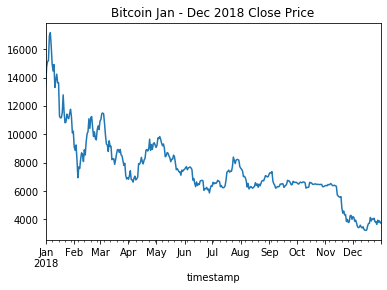

In [318]:
crypto_btc18.close.plot()
plt.title('Bitcoin Jan - Dec 2018 Close Price')

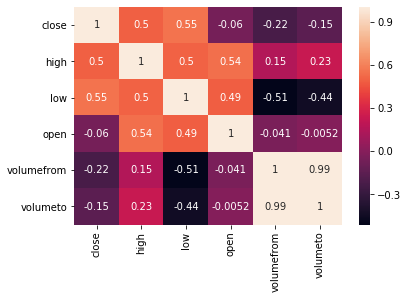

In [325]:
crypto_btc18_pct = crypto_btc18.pct_change()
sns.heatmap(crypto_btc18_pct.corr(), annot = True)

In [520]:
from scipy.stats import norm
def plot_hist(df, column, bin_amount=25):
    mu, std = norm.fit(df[column])
    plt.hist(df[column], bins=bin_amount, density=True, alpha=0.8, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.xlabel(col)
    plt.show()

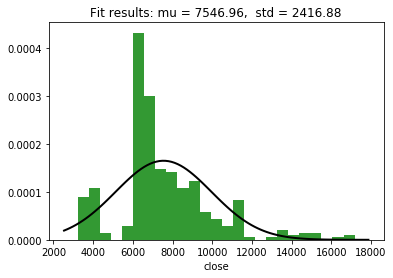

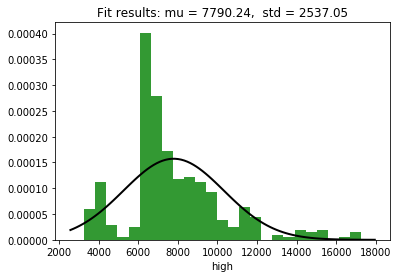

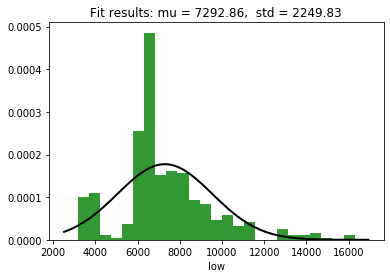

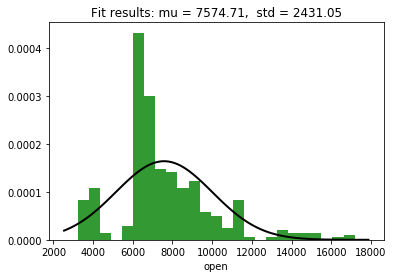

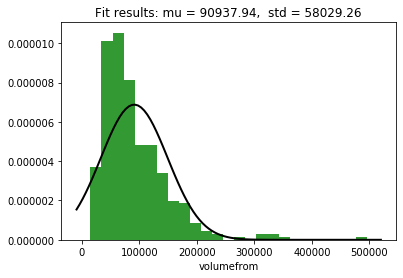

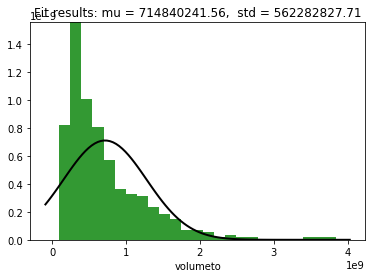

In [523]:
for col in crypto_btc18.columns:
    plot_hist(crypto_btc18, col)

### Blockchain Dataset

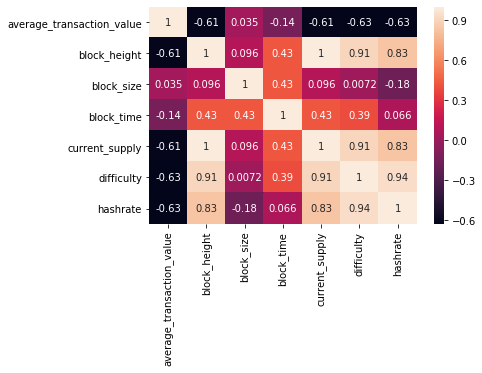

In [472]:
block_corr = blockchain_btc18.select_dtypes(include='float64').corr()
sns.heatmap(block_corr, annot=True)

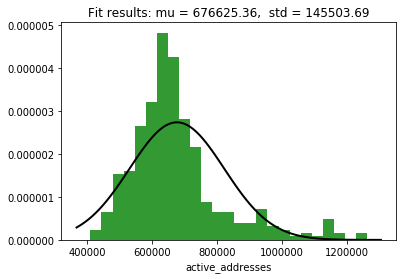

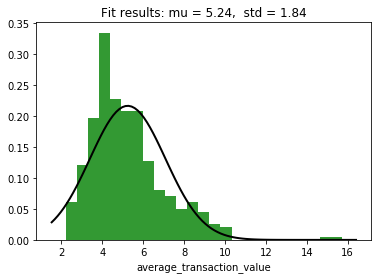

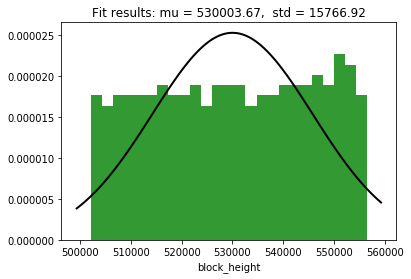

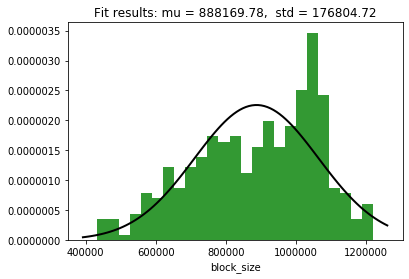

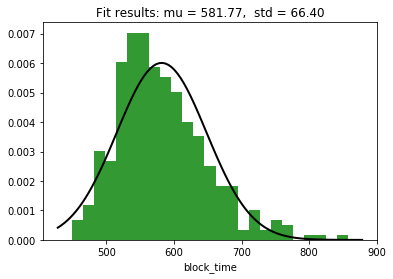

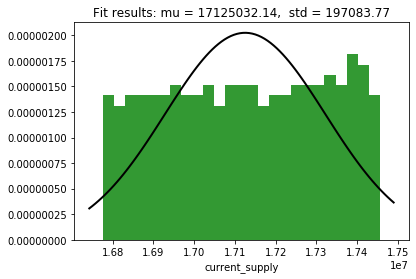

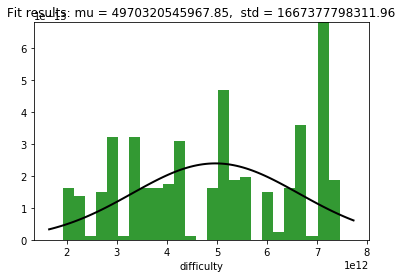

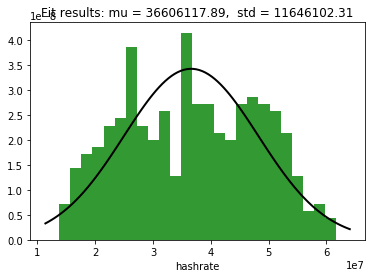

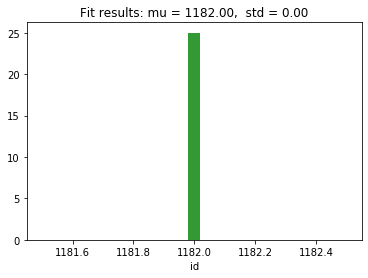

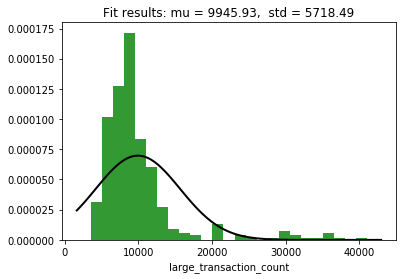

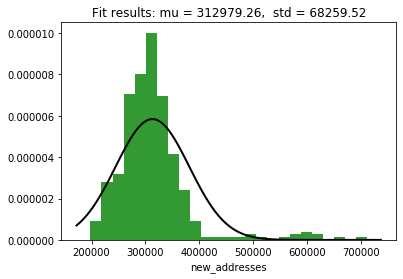

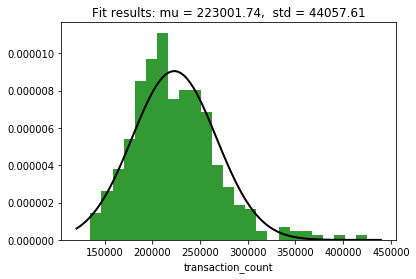

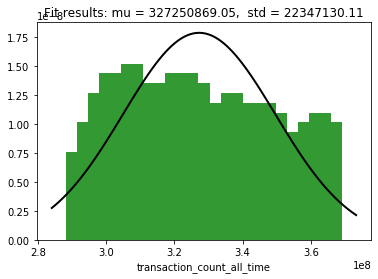

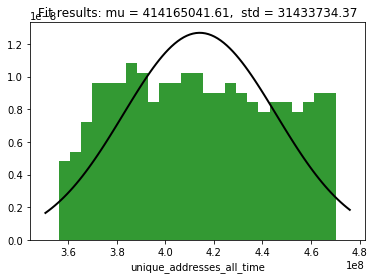

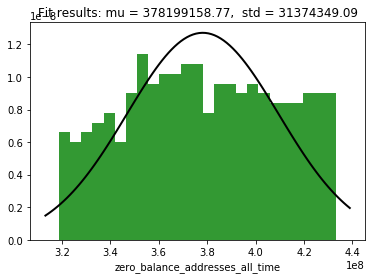

In [524]:
for col in blockchain_btc18.columns:
    plot_hist(blockchain_btc18, col)

### Social Dataset
- **Most values are counts - feature engineering?**

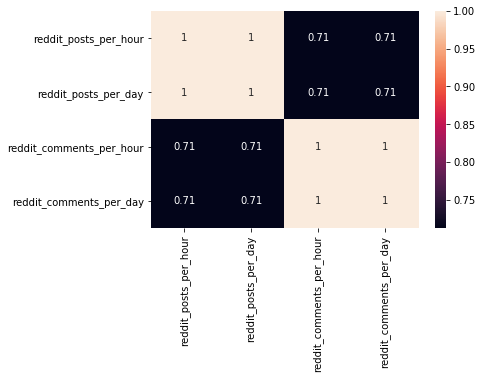

In [476]:
social_corr = social_btc18.select_dtypes(include='float64').corr()
sns.heatmap(social_corr, annot=True)

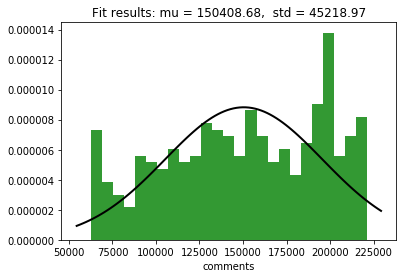

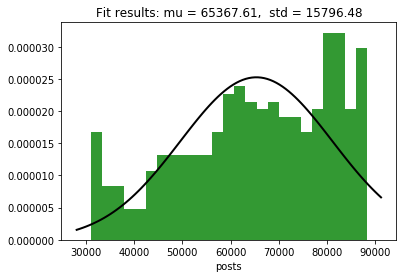

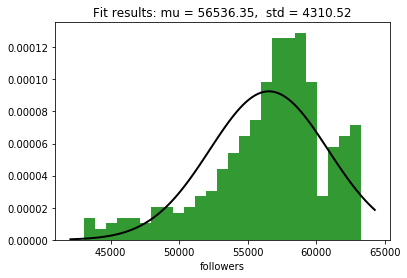

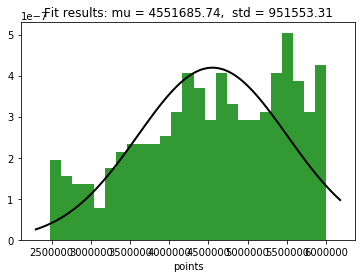

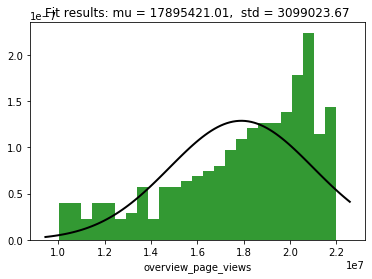

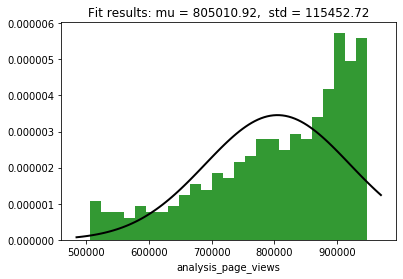

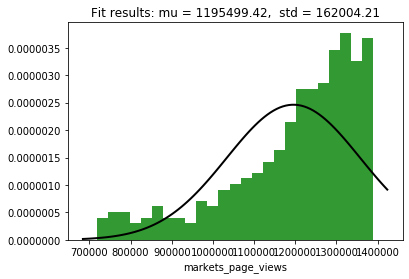

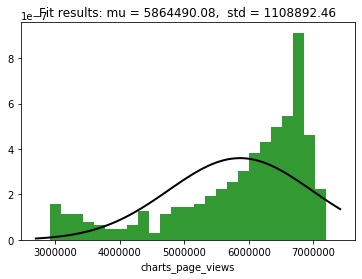

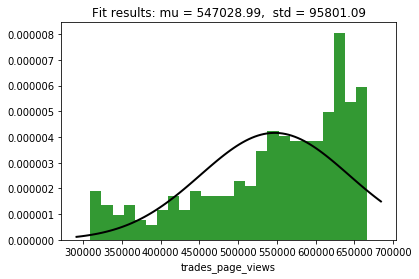

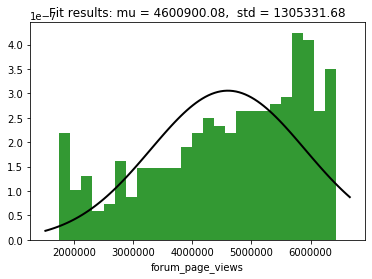

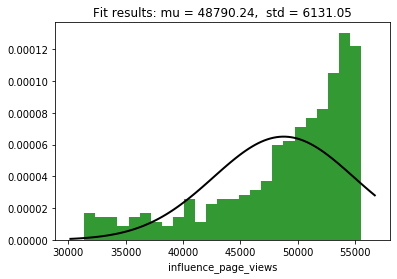

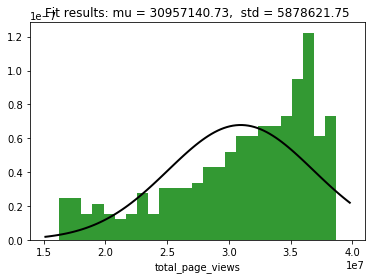

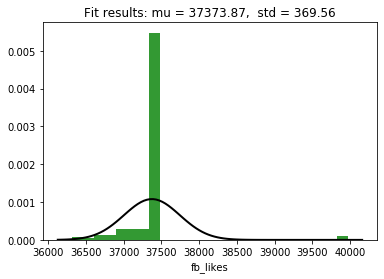

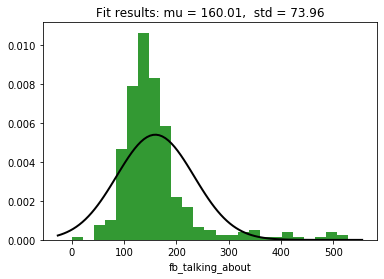

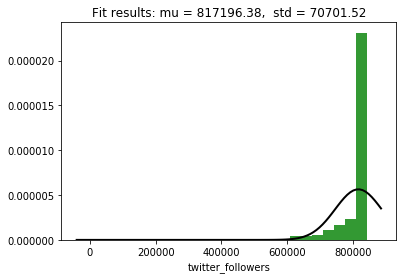

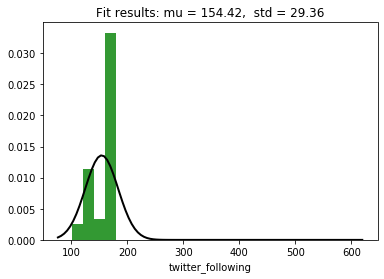

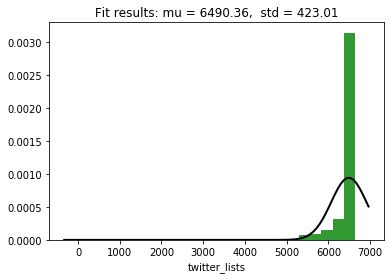

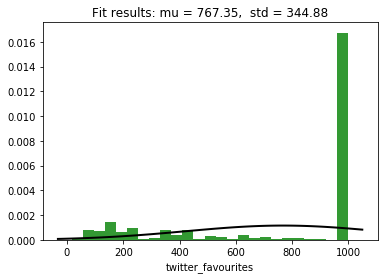

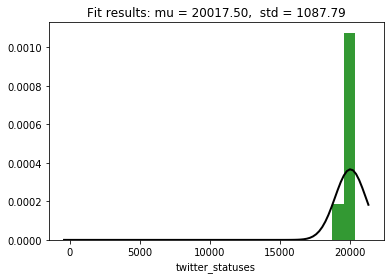

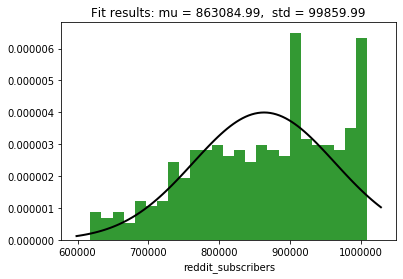

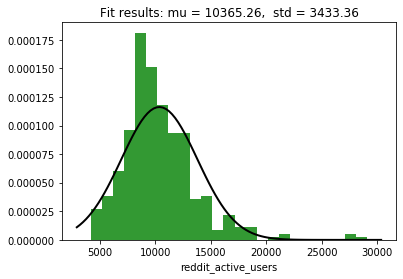

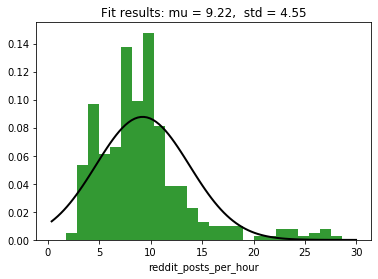

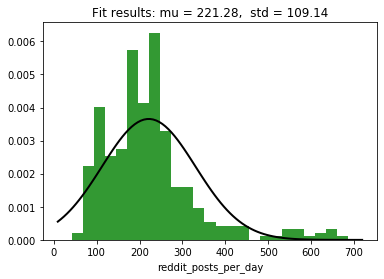

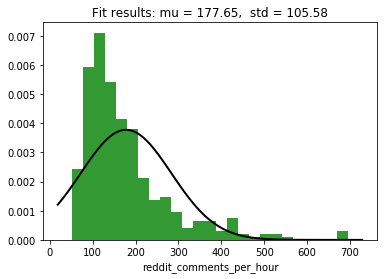

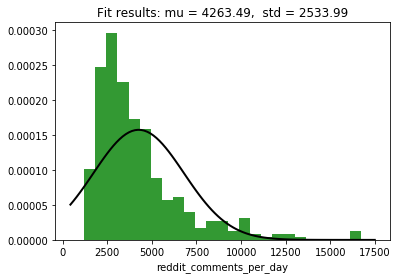

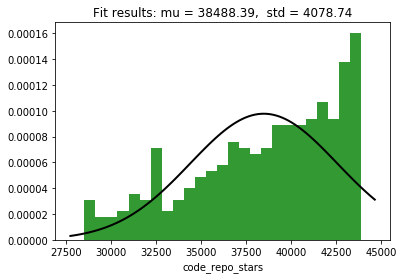

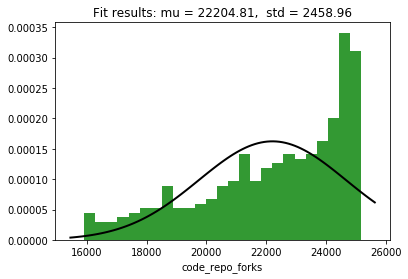

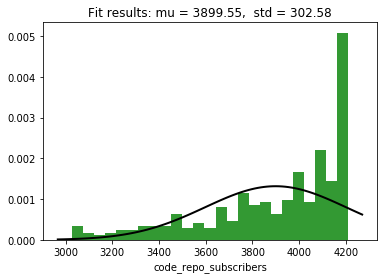

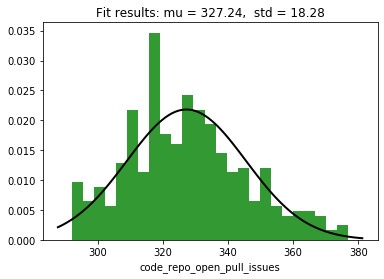

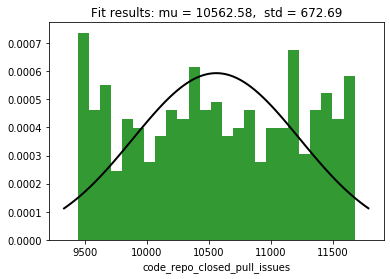

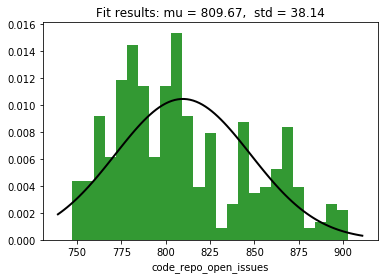

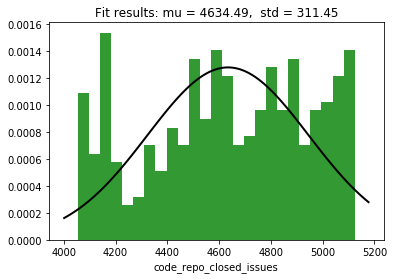

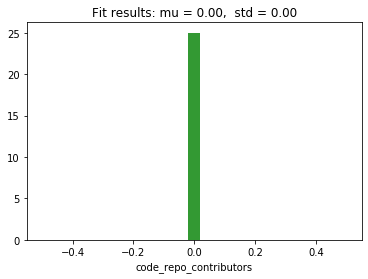

In [525]:
for col in social_btc18.columns:
    plot_hist(social_btc18, col)

### Correlation All

In [328]:
merge_all = pd.concat([blockchain_btc18,social_btc18,crypto_btc18],axis = 1)
cols_all = merge_all.columns

In [330]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(merge_all)
scaled = pd.DataFrame(scaled)
scaled.columns = cols_all
scaled.index = merge_all.index
scaled.head()

,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,id,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,close,high,low,open,volumefrom,volumeto
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.658761,0.351694,0.000000,0.773773,0.251262,0.000000,0.000000,0.024927,0.0,0.443270,0.353521,0.367836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440454,0.726272,0.008097,0.805761,0.061038,0.932814,0.000000,0.311408,0.626022,0.626049,0.474701,0.474700,0.000000,0.000000,0.000000,0.035294,0.000000,0.346154,0.000000,0.0,0.732606,0.761727,0.740117,0.761583,0.132509,0.256969
2018-01-02,0.866263,0.386998,0.003147,0.771226,0.135076,0.003147,0.001547,0.055959,0.0,0.791266,0.722302,0.710127,0.004202,0.004992,0.004100,0.003183,0.005081,0.013640,0.005448,0.007193,0.006710,0.011047,0.005069,0.005292,0.003668,0.008574,0.006127,0.008188,0.408318,0.732118,0.008097,0.808475,0.061038,0.932915,0.008945,0.427456,0.841264,0.840975,0.633648,0.633641,0.005599,0.004977,0.004219,0.047059,0.001792,0.352564,0.000935,0.0,0.826528,0.860760,0.744423,0.732490,0.255751,0.496879
2018-01-03,0.854896,0.362890,0.006036,0.801758,0.246007,0.006036,0.001547,0.027549,0.0,0.825403,0.889227,0.899803,0.009081,0.010736,0.007796,0.005164,0.007674,0.030255,0.009768,0.013902,0.013878,0.021709,0.009183,0.009877,0.006486,0.018307,0.011623,0.015011,0.449905,0.739379,0.008097,0.813904,0.061038,0.932965,0.018822,0.347460,0.691450,0.691165,0.325311,0.325307,0.012305,0.012658,0.009283,0.023529,0.004480,0.346154,0.001871,0.0,0.855401,0.869979,0.869875,0.826394,0.190940,0.402817
2018-01-04,1.000000,0.313201,0.009127,0.802161,0.158791,0.009127,0.001547,0.049463,0.0,1.000000,1.000000,1.000000,0.014318,0.016980,0.011561,0.005485,0.008370,0.033975,0.010727,0.015410,0.015795,0.024669,0.010158,0.010891,0.007056,0.019964,0.012877,0.015557,0.427221,0.742008,0.008097,0.814809,0.061038,0.933067,0.021971,0.261617,0.473978,0.473746,0.219424,0.219415,0.015299,0.016445,0.011814,0.035294,0.004480,0.358974,0.001871,0.0,0.857084,0.868094,0.844332,0.855257,0.200136,0.416825
2018-01-05,0.779772,0.467117,0.011759,0.804441,0.374494,0.011759,0.001547,0.000000,0.0,0.913034,0.776754,0.716085,0.018541,0.022217,0.014736,0.009599,0.011311,0.058129,0.017224,0.025463,0.025799,0.040546,0.016467,0.018416,0.011514,0.031188,0.021178,0.040120,0.478261,0.756866,0.008097,0.827025,0.061038,0.933624,0.038306,0.460383,0.456506,0.456507,0.737908,0.737896,0.027865,0.030185,0.030380,0.035294,0.009409,0.358974,0.005613,0.0,0.984396,0.990995,0.889136,0.856949,0.264537,0.584172


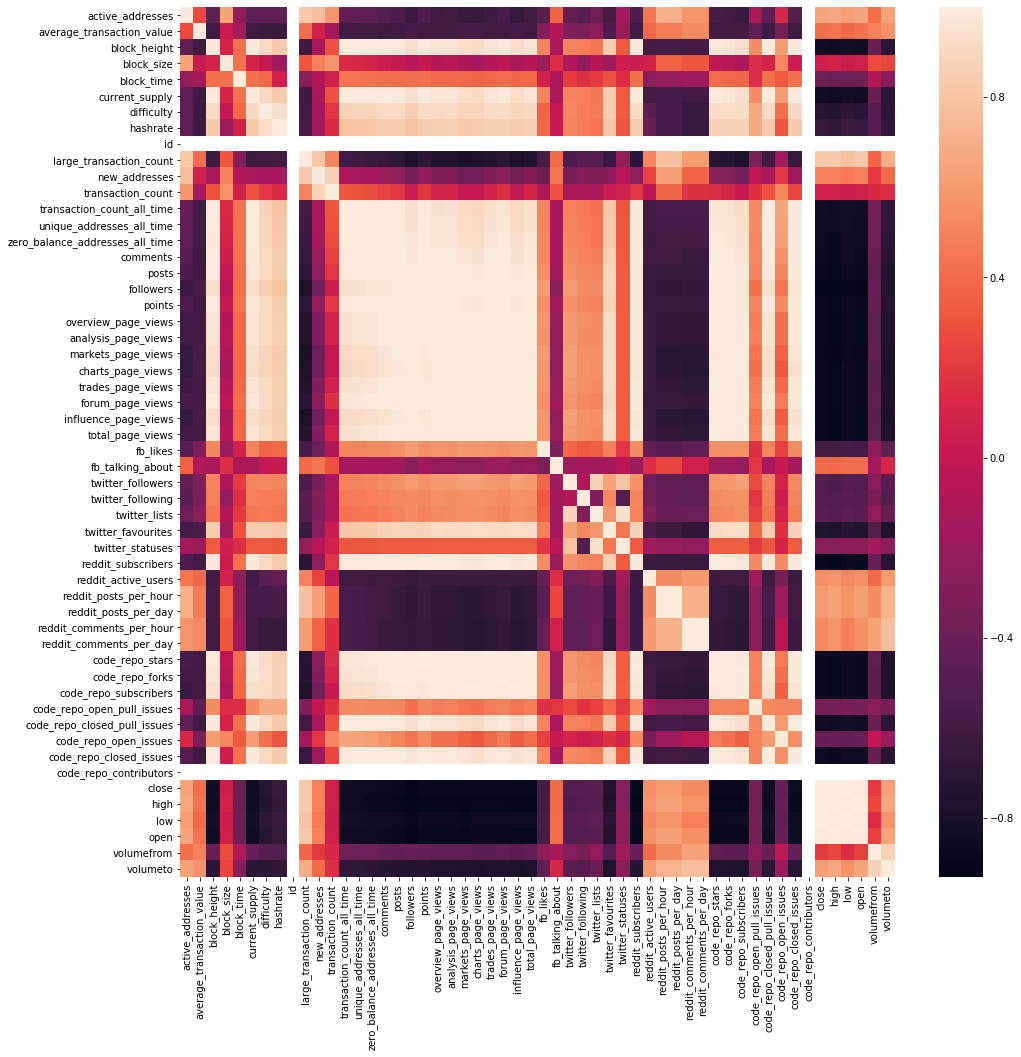

In [477]:
plt.figure(figsize=(16, 16))
sns.heatmap(scaled.corr())

## Boxplots 

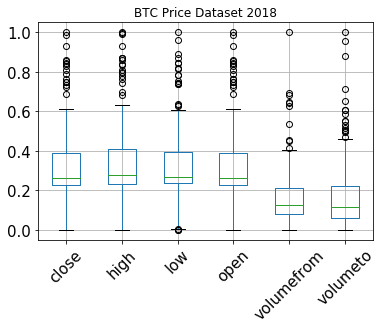

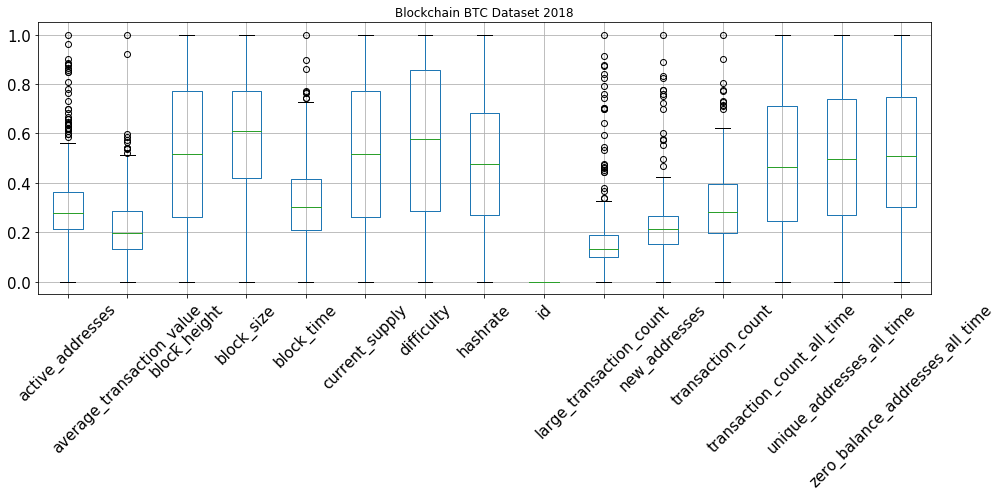

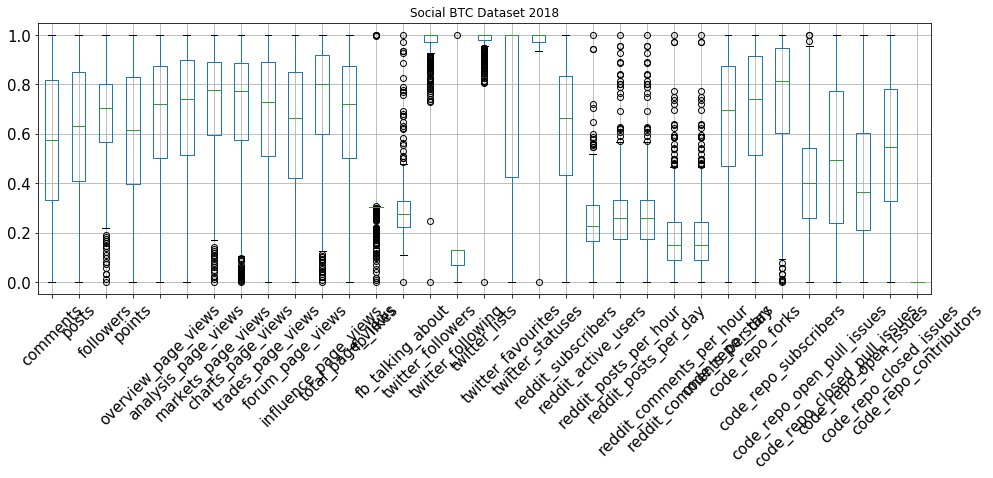

In [490]:
scaled[crypto_btc18.columns].boxplot(rot=45, fontsize=15)
plt.title('BTC Price Dataset 2018')
plt.show()

plt.subplots(figsize=(16,5))
scaled[blockchain_btc18.columns].boxplot(rot=45, fontsize=15)
plt.title('Blockchain BTC Dataset 2018')
plt.show()

plt.subplots(figsize=(16,5))
scaled[social_btc18.columns].boxplot(rot=45, fontsize=15)
plt.title('Social BTC Dataset 2018')
plt.show()

## Anomaly Detection In Cryptocurrencies 

![](confusion_matrix_ilustration.jpeg)

## ARIMA Test on BTC Close price (Not so relavent just wanted to try)

MSE: 0.000


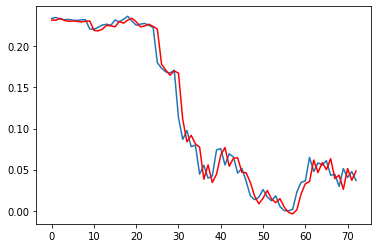

In [492]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

p = 5  # lag
d = 1  # difference order
q = 0  # size of moving average window

train, test = train_test_split(scaled.close.values, test_size=0.20, shuffle=False)
history = train.tolist()
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    fit = model.fit(disp=False)
    pred = fit.forecast()[0]

    predictions.append(pred)
    history.append(test[t])

print('MSE: %.3f' % mean_squared_error(test, predictions))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# An Awesome Tutorial to Learn Outlier Detection in Python using PyOD Library
Source: https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

## Model Descriptions 

### Angle-Based Outlier Detection (ABOD)
- It considers the relationship between each point and its neighbor(s). It does not consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score. ABOD performs well on multi-dimensional dataPyOD provides two different versions of ABOD:
    - Fast ABOD: Uses k-nearest neighbors to approximate
    - Original ABOD: Considers all training points with high-time complexity

### k-Nearest Neighbors Detector
- For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score. PyOD supports three kNN detectors:
    - Largest: Uses the distance of the kth neighbor as the outlier score
    - Mean: Uses the average of all k neighbors as the outlier score
    - Median: Uses the median of the distance to k neighbors as the outlier score
    
### Isolation Forest
- It uses the scikit-learn library internally. In this method, data partitioning is done using a set of trees. Isolation Forest provides an anomaly score looking at how isolated the point is in the structure. The anomaly score is then used to identify outliers from normal observations
- Isolation Forest performs well on multi-dimensional data

### Histogram-based Outlier Detection
- It is an efficient unsupervised method which assumes the feature independence and calculates the outlier score by building histograms
- It is much faster than multivariate approaches, but at the cost of less precision

### Local Correlation Integral (LOCI)
- LOCI is very effective for detecting outliers and groups of outliers. It provides a LOCI plot for each point which summarizes a lot of the information about the data in the area around the point, determining clusters, micro-clusters, their diameters, and their inter-cluster distances
- None of the existing outlier-detection methods can match this feature because they output only a single number for each point

### Feature Bagging
- A feature bagging detector fits a number of base detectors on various sub-samples of the dataset. It uses averaging or other combination methods to improve the prediction accuracy
- By default, Local Outlier Factor (LOF) is used as the base estimator. However, any estimator could be used as the base estimator, such as kNN and ABOD
- Feature bagging first constructs n sub-samples by randomly selecting a subset of features. This brings out the diversity of base estimators. Finally, the prediction score is generated by averaging or taking the maximum of all base detectors

### Clustering Based Local Outlier Factor
- It classifies the data into small clusters and large clusters. The anomaly score is then calculated based on the size of the cluster the point belongs to, as well as the distance to the nearest large cluster

## Detection Outliers for Close Price and Volumeto

In [88]:
# Import models
#from pyod.models.abod import ABOD
#from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
#from pyod.models.hbos import HBOS
#from pyod.models.iforest import IForest
#from pyod.models.knn import KNN
#from pyod.models.lof import LOF

In [340]:
# re-select scaled features 
crypto_scaled = scaled[crypto_btc18.columns]
social_scaled = scaled[social_btc18.columns]
blockchian_scaled = scaled[blockchain_btc18.columns]

- Store these values in the NumPy array for using in our models later:

In [395]:
# used to give a new shape to an array without changing its data
X1 = scaled['close'].values.reshape(-1,1)
X2 = scaled['volumeto'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

- Create a dictionary and add all the models that you want to use to detect the outliers:

You can set the value of the outlier fraction according to your problem and your understanding of the data. In our example, I want to detect 5% observations that are not similar to the rest of the data. So, I’m going to set the value of outlier fraction as 0.05

In [396]:
#outlier_fraction = 0.05
#classifiers = {
#     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
#     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
#}

In [397]:
random_state = np.random.RandomState(123)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

- Fit the data to each model we have added in the dictionary, Then, see how each model is detecting outliers:

OUTLIERS :  19 INLIERS :  346 Angle-based Outlier Detector (ABOD)


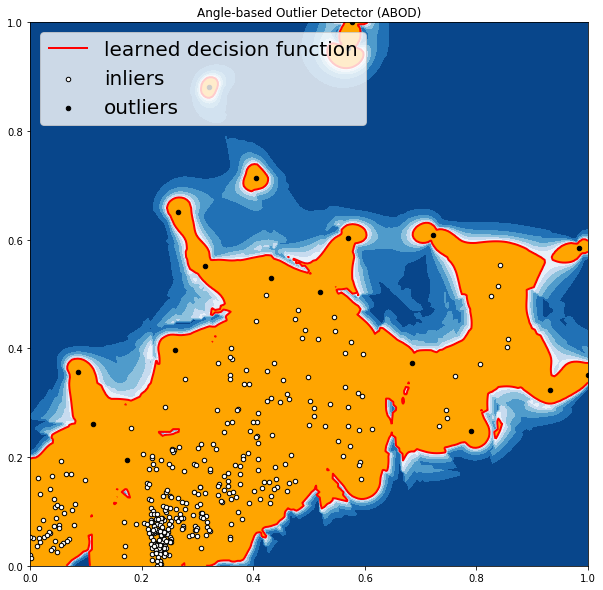

OUTLIERS :  19 INLIERS :  346 Cluster-based Local Outlier Factor (CBLOF)


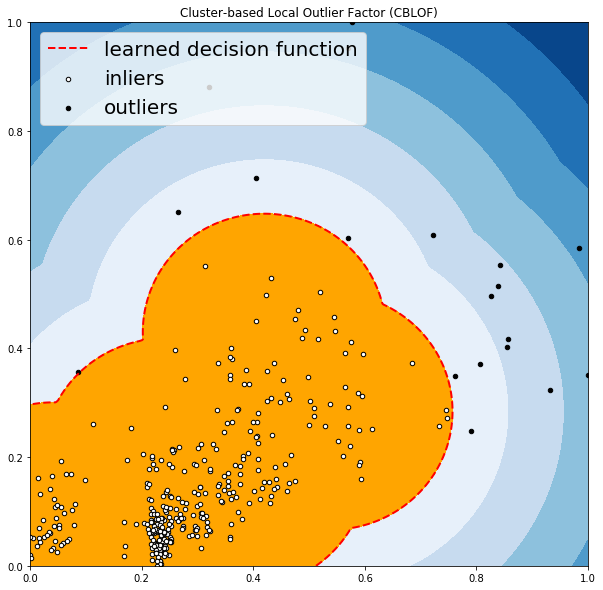

OUTLIERS :  16 INLIERS :  349 Feature Bagging


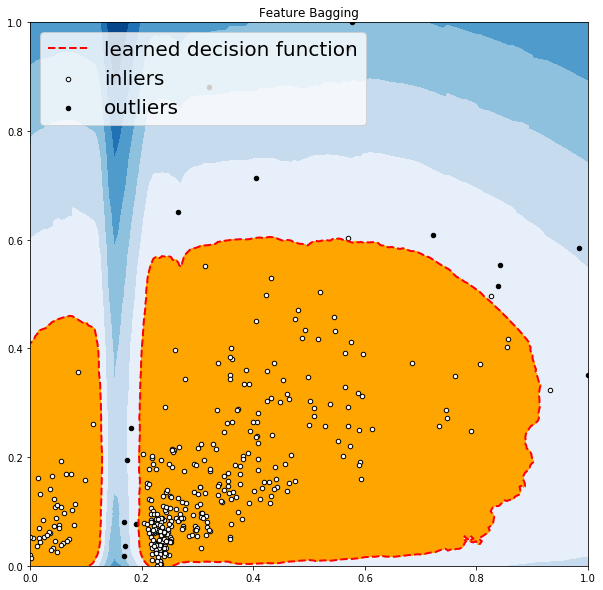

OUTLIERS :  19 INLIERS :  346 Histogram-base Outlier Detection (HBOS)


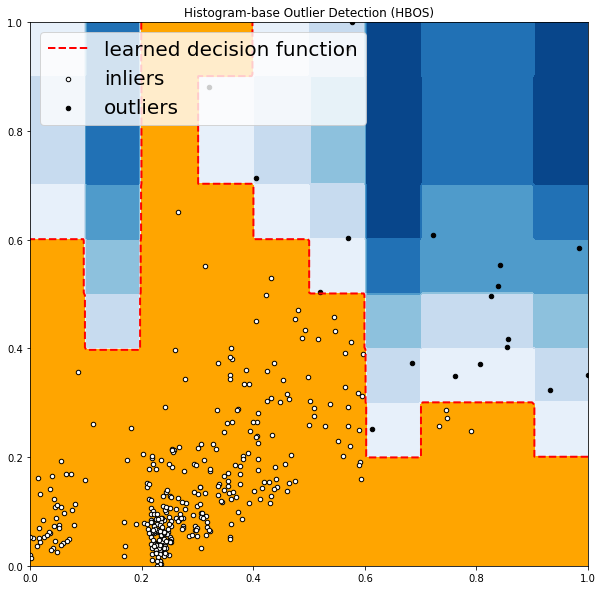

OUTLIERS :  19 INLIERS :  346 Isolation Forest


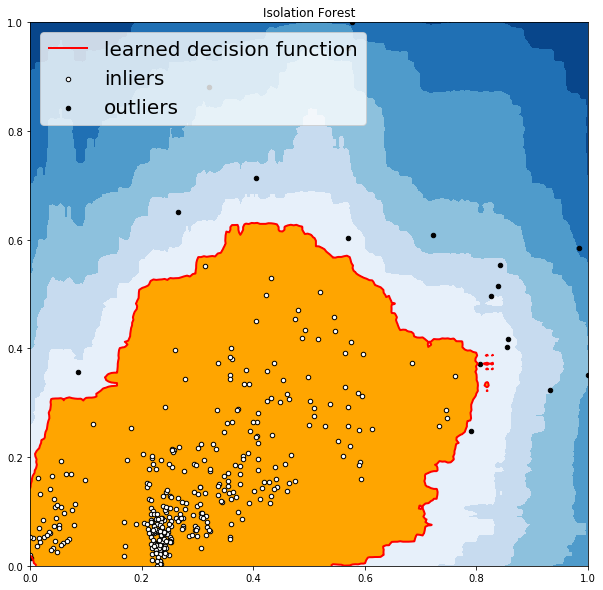

OUTLIERS :  13 INLIERS :  352 K Nearest Neighbors (KNN)


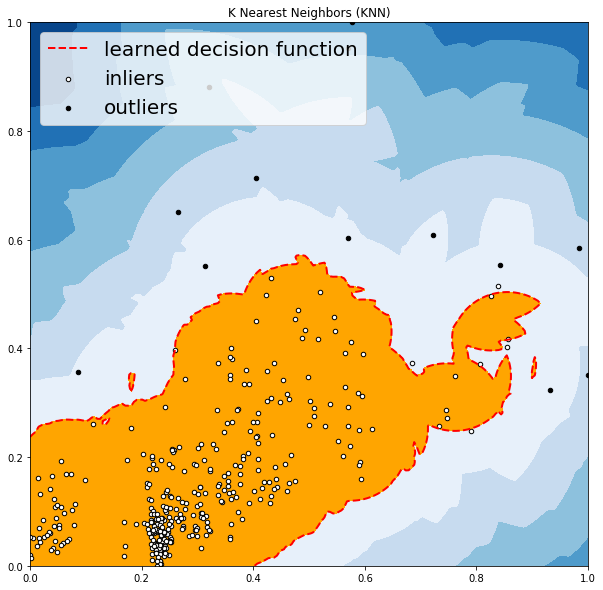

OUTLIERS :  12 INLIERS :  353 Average KNN


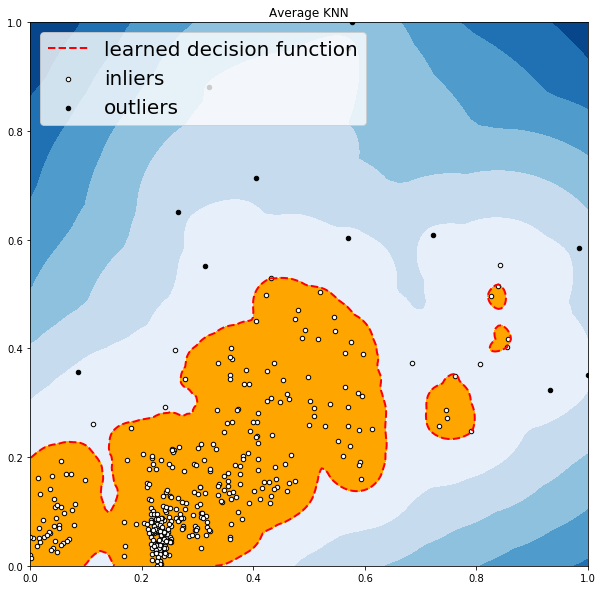

In [398]:
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
# create a rectangular grid out of two given one-dimensional arrays representing the Cartesian indexing or Matrix indexing
# creates sequences of evenly spaced numbers structured as a NumPy array
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))
df_outliers = []
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
    
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = scaled.copy()[['close','volumeto']]
    dfx[clf_name] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['close'][dfx[clf_name] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['volumeto'][dfx[clf_name] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['close'][dfx[clf_name] == 1].values.reshape(-1,1)
    OX2 =  dfx['volumeto'][dfx[clf_name] == 1].values.reshape(-1,1)
    
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * 0.05)
    
    # ravel returns contiguous flattened array(1D array with all the input-array elements and with the same type as it).
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
    
    plt.axis('tight')
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()
    
    df_outliers.append(dfx[clf_name]) 

## Edentify Dates 

In [399]:
# make outlier lists from models a dataframe and transpose 
df_outliers = pd.DataFrame(df_outliers).T
df_outliers = df_outliers.reset_index()

Text(0.5, 1.0, 'Model Anomalies BTC Close and Volumeto 2018 (1 = Outlier)')

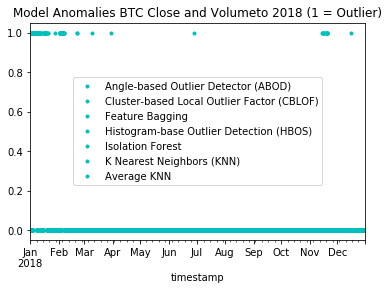

In [526]:
df_outliers.set_index('timestamp').plot(style='c.')
plt.title('Model Anomalies BTC Close and Volumeto 2018 (1 = Outlier)')

In [401]:
# number of 
for col in df_outliers.columns:
    print(df_outliers[col].value_counts())

2018-01-31    1
2018-05-20    1
2018-03-19    1
2018-02-16    1
2018-01-16    1
             ..
2018-04-18    1
2018-03-18    1
2018-02-15    1
2018-01-15    1
2018-12-21    1
Name: timestamp, Length: 365, dtype: int64
0    346
1     19
Name: Angle-based Outlier Detector (ABOD), dtype: int64
0    346
1     19
Name: Cluster-based Local Outlier Factor (CBLOF), dtype: int64
0    349
1     16
Name: Feature Bagging, dtype: int64
0    346
1     19
Name: Histogram-base Outlier Detection (HBOS), dtype: int64
0    346
1     19
Name: Isolation Forest, dtype: int64
0    352
1     13
Name: K Nearest Neighbors (KNN), dtype: int64
0    353
1     12
Name: Average KNN, dtype: int64


## What dates did the models identify as outliers?  

In [402]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in df_outliers.columns:
    outliers = df_outliers[df_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.timestamp) # append the string/date

## Dates that were the same (Sorted by CBLOF)

In [403]:
common_dates = pd.DataFrame(outlier_dates).T

In [404]:
common_dates.columns = df_outliers.columns
common_dates = common_dates.drop('timestamp',axis = 1)

In [405]:
common = \
    set.intersection(set(common_dates['Cluster-based Local Outlier Factor (CBLOF)']))

In [409]:
pd.options.display.max_rows = 134
pd.concat([
    common_dates[common_dates['Cluster-based Local Outlier Factor (CBLOF)'].isin(common)].sort_values(
    by='Cluster-based Local Outlier Factor (CBLOF)')]).head(10)

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
1,NaT,2018-01-02,NaT,2018-01-02,2018-01-02,NaT,NaT
2,NaT,2018-01-03,NaT,2018-01-03,2018-01-03,NaT,NaT
3,NaT,2018-01-04,NaT,2018-01-04,2018-01-04,NaT,NaT
4,2018-01-05,2018-01-05,2018-01-05,2018-01-05,2018-01-05,2018-01-05,2018-01-05
5,2018-01-06,2018-01-06,2018-01-06,2018-01-06,2018-01-06,2018-01-06,2018-01-06
6,2018-01-07,2018-01-07,NaT,2018-01-07,2018-01-07,2018-01-07,2018-01-07
7,NaT,2018-01-08,2018-01-08,2018-01-08,2018-01-08,2018-01-08,NaT
8,NaT,2018-01-09,NaT,2018-01-09,2018-01-09,NaT,NaT
9,NaT,2018-01-10,2018-01-10,2018-01-10,2018-01-10,NaT,NaT
10,2018-01-11,2018-01-11,2018-01-11,2018-01-11,2018-01-11,2018-01-11,2018-01-11


In [609]:
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [616]:
outlier_datapoints = detect_outlier(crypto_btc18.open)
print(outlier_datapoints)

TypeError: cannot concatenate object of type '<class 'float'>'; only Series and DataFrame objs are valid

## Find Anomalies 3-Standard Deviations for Close Price Returns

In [669]:
# get list of outliers 
crypto_btc18_pct1 = crypto_btc18_pct.dropna()
mean = np.mean(crypto_btc18_pct1.close, axis=0)
sd = np.std(crypto_btc18_pct1.close, axis=0)

final_list = [x for x in crypto_btc18_pct1.close if (x > mean - 3 * sd)]
final_list = [x for x in final_list if (x < mean + 3 * sd)]
print('nbr of outliers: ',len(final_list))
print('First 20: ','\n',final_list[:20])

nbr of outliers:  360
First 20:  
 [0.09737907664478973, 0.02727981927772105, 0.0015478385022518193, 0.11690979230675991, 0.012829420375846778, -0.05498040448862407, -0.07714922702265692, -0.033898520115623665, 0.031170473787883957, -0.10800838366458909, 0.04006068502847149, 0.029038688147478675, -0.042440841613354485, -0.0004875856299348946, -0.010617337130367388, 0.0011484676646331682, 0.03098200352198366, 0.10954749968754784, -0.09652814390555653, -0.06367224736426969]


In [671]:
# get corresponding dates 
index_list = crypto_btc18_pct1.reset_index()
dates_list = []
for e in final_list:
    search = index_list.set_index('close').loc[e,'timestamp']
    dates_list.append(search)
print(dates_list[:20])

[Timestamp('2018-01-02 00:00:00'), Timestamp('2018-01-03 00:00:00'), Timestamp('2018-01-04 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-06 00:00:00'), Timestamp('2018-01-07 00:00:00'), Timestamp('2018-01-08 00:00:00'), Timestamp('2018-01-09 00:00:00'), Timestamp('2018-01-10 00:00:00'), Timestamp('2018-01-11 00:00:00'), Timestamp('2018-01-12 00:00:00'), Timestamp('2018-01-13 00:00:00'), Timestamp('2018-01-14 00:00:00'), Timestamp('2018-01-15 00:00:00'), Timestamp('2018-01-17 00:00:00'), Timestamp('2018-01-18 00:00:00'), Timestamp('2018-01-19 00:00:00'), Timestamp('2018-01-20 00:00:00'), Timestamp('2018-01-21 00:00:00'), Timestamp('2018-01-22 00:00:00')]


## Links to tutorials and failure code onward
- https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb

In [580]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.05
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [581]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 190
Number of outliers: 10
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [593]:
random_state = np.random.RandomState(123)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction,novelty=True),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)
3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Average KNN
8 fitting Local Outlier Factor (LOF)
9 fitting Minimum Covariance Determinant (MCD)
10 fitting One-class SVM (OCSVM)
11 fitting Principal Component Analysis (PCA)
12 fitting Locally Selective Combination (LSCP)


ValueError: x and y must have length at least 2.

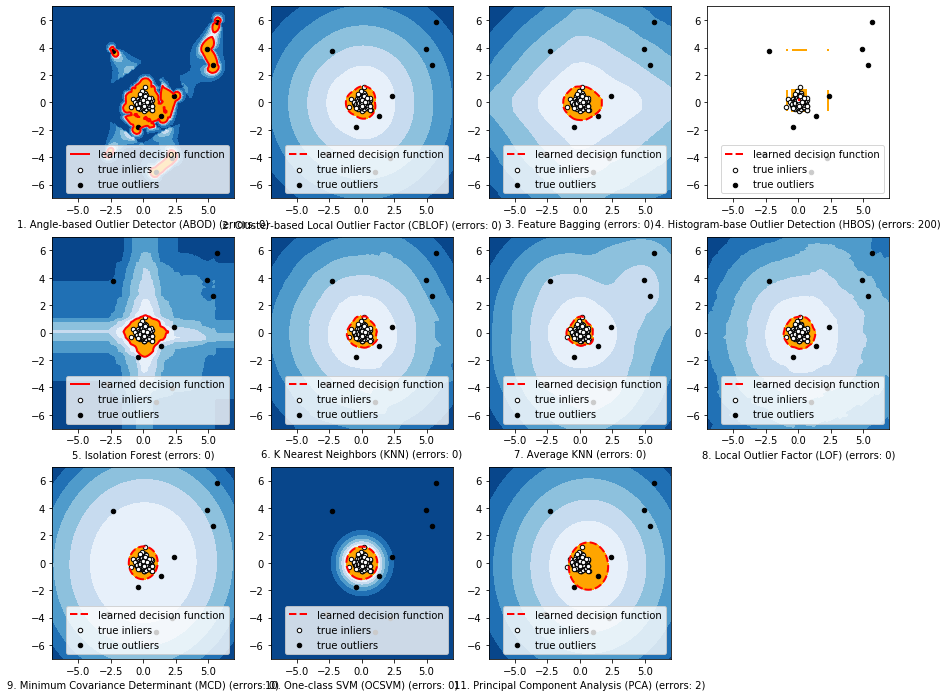

In [594]:
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()

### Anomaly Detection with time series forecasting
- https://towardsdatascience.com/anomaly-detection-with-time-series-forecasting-c34c6d04b24a
- https://statsbot.co/blog/time-series-anomaly-detection-algorithms/

### Classification PYOD
- https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9

## Price Dataset Kmeans
https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46
- Didn't work for me for some reason 

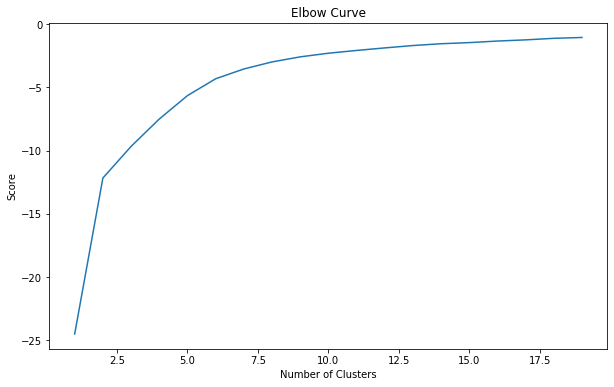

In [542]:
# selected 3 features I "assume" most important from dataset
data = scaled[['close','volumeto','volumefrom']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

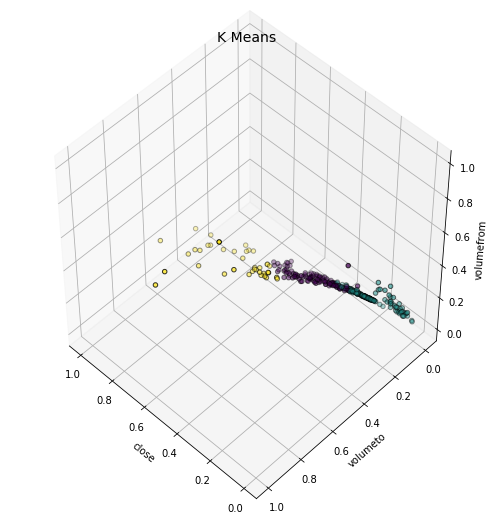

In [544]:
from mpl_toolkits.mplot3d import Axes3D
X = scaled[['close','volumeto','volumefrom']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=3)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("close")
ax.set_ylabel("volumeto")
ax.set_zlabel("volumefrom")
plt.title("K Means", fontsize=14);

Now we need to find out the number of components (features) to keep.
- first component explains 70% of variance, 2nd around 25% (so we set it to n_components = 2)

**The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.**

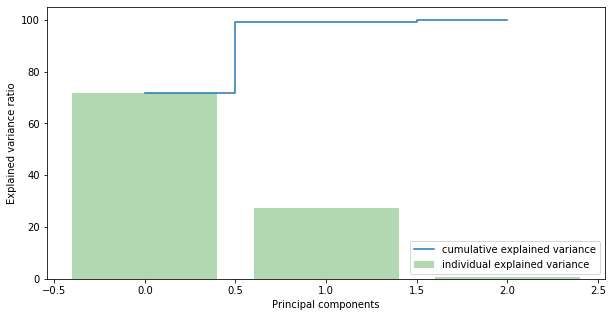

In [566]:
data = scaled[['close','volumeto','volumefrom']]
X = data.values
mean_vec = np.mean(X, axis=0)
cov_mat = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

- Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.

In [571]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

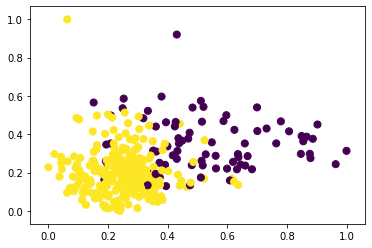

In [531]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(crypto_btc18.values, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Hierarchical Clustering — Unsupervised

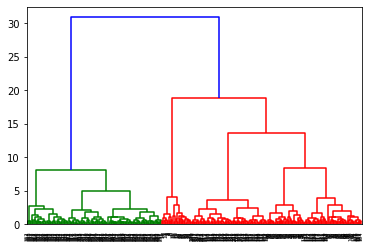

In [447]:
from sklearn.cluster import AgglomerativeClustering

clusters = 3
y_pred = AgglomerativeClustering(n_clusters=clusters).fit_predict(X)


from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

clusters=5
cls = linkage(X, method='ward')
y_pred = fcluster(cls, t=clusters, criterion='maxclust')

dendrogram(cls)
plt.show()

### LSTM (Didn't get it to work)

In [451]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential

class LSTM_Autoencoder:
    def __init__(self, optimizer='adam', loss='mse'):
        self.optimizer = optimizer
        self.loss = loss
        self.n_features = 1

    def build_model(self):
        timesteps = self.timesteps
        n_features = self.n_features
        model = Sequential()

        # Encoder
        model.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
        model.add(LSTM(16, activation='relu', return_sequences=True))
        model.add(LSTM(1, activation='relu'))
        model.add(RepeatVector(timesteps))

        # Decoder
        model.add(LSTM(timesteps, activation='relu', return_sequences=True))
        model.add(LSTM(16, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(n_features)))

        model.compile(optimizer=self.optimizer, loss=self.loss)
        model.summary()
        self.model = model

    def fit(self, X, epochs=3, batch_size=32):
        self.timesteps = X.shape[1]
        self.build_model()

        input_X = np.expand_dims(X, axis=2)
        self.model.fit(input_X, input_X, epochs=epochs, batch_size=batch_size)

    def predict(self, X):
        input_X = np.expand_dims(X, axis=2)
        output_X = self.model.predict(input_X)
        reconstruction = np.squeeze(output_X)
        return np.linalg.norm(X - reconstruction, axis=-1)

    def plot(self, scores, timeseries, threshold=0.95):
        sorted_scores = sorted(scores)
        threshold_score = sorted_scores[round(len(scores) * threshold)]

        plt.title("Reconstruction Error")
        plt.plot(scores)
        plt.plot([threshold_score]*len(scores), c='r')
        plt.show()

        anomalous = np.where(scores > threshold_score)
        normal = np.where(scores <= threshold_score)

        plt.title("Anomalies")
        plt.scatter(normal, timeseries[normal][:,-1], s=3)
        plt.scatter(anomalous, timeseries[anomalous][:,-1], s=5, c='r')
        plt.show()

lstm_autoencoder = LSTM_Autoencoder(optimizer='adam', loss='mse')
lstm_autoencoder.fit(normal_timeseries, epochs=3, batch_size=32)
scores = lstm_autoencoder.predict(test_timeseries)
lstm_autoencoder.plot(scores, test_timeseries, threshold=0.95)

NameError: name 'normal_timeseries' is not defined

In [ ]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

In [27]:
from sklearn.cluster import KMeans

clusters = 3
y_pred = KMeans(n_clusters=clusters).fit_predict(btc1.close)

plt.scatter(btc1.close[:,0], btc1.close[:,1], c=y_pred)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0.00000000e+00 1.87796189e-06 1.61743539e-06 ... 4.53110928e-01
 4.53529631e-01 4.62055671e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [78]:
# Store these values in the NumPy array for using in our models later
X1 = btc1['close'].values.reshape(-1,1)
X2 = btc1['volumeto'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [67]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [70]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

ValueError:  is set to 5. Not in the range of (1, 5).

In [79]:
from kenchi.outlier_detection.statistical import HBOS

hbos = HBOS(novelty=True).fit(X)
y_pred = hbos.predict(X)

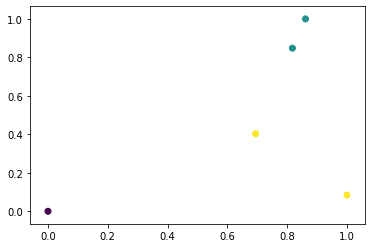

In [81]:
from sklearn.cluster import KMeans

clusters = 3
y_pred = KMeans(n_clusters=clusters).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

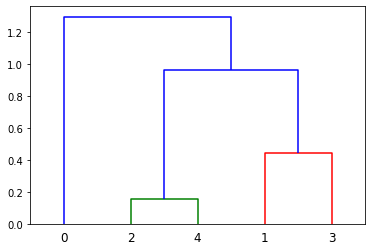

In [82]:
from sklearn.cluster import AgglomerativeClustering

clusters = 3
y_pred = AgglomerativeClustering(n_clusters=clusters).fit_predict(X)


from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

clusters=5
cls = linkage(X, method='ward')
y_pred = fcluster(cls, t=clusters, criterion='maxclust')

dendrogram(cls)
plt.show()

In [457]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential

class LSTM_Autoencoder:
    def __init__(self, optimizer='adam', loss='mse'):
        self.optimizer = optimizer
        self.loss = loss
        self.n_features = 1

    def build_model(self):
        timesteps = self.timesteps
        n_features = self.n_features
        model = Sequential()

        # Encoder
        model.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
        model.add(LSTM(16, activation='relu', return_sequences=True))
        model.add(LSTM(1, activation='relu'))
        model.add(RepeatVector(timesteps))

        # Decoder
        model.add(LSTM(timesteps, activation='relu', return_sequences=True))
        model.add(LSTM(16, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(n_features)))

        model.compile(optimizer=self.optimizer, loss=self.loss)
        model.summary()
        self.model = model

    def fit(self, X, epochs=3, batch_size=32):
        self.timesteps = X.shape[1]
        self.build_model()

        input_X = np.expand_dims(X, axis=2)
        self.model.fit(input_X, input_X, epochs=epochs, batch_size=batch_size)

    def predict(self, X):
        input_X = np.expand_dims(X, axis=2)
        output_X = self.model.predict(input_X)
        reconstruction = np.squeeze(output_X)
        return np.linalg.norm(X - reconstruction, axis=-1)

    def plot(self, scores, timeseries, threshold=0.95):
        sorted_scores = sorted(scores)
        threshold_score = sorted_scores[round(len(scores) * threshold)]

        plt.title("Reconstruction Error")
        plt.plot(scores)
        plt.plot([threshold_score]*len(scores), c='r')
        plt.show()

        anomalous = np.where(scores > threshold_score)
        normal = np.where(scores <= threshold_score)

        plt.title("Anomalies")
        plt.scatter(normal, timeseries[normal][:,-1], s=3)
        plt.scatter(anomalous, timeseries[anomalous][:,-1], s=5, c='r')
        plt.show()

lstm_autoencoder = LSTM_Autoencoder(optimizer='adam', loss='mse')
lstm_autoencoder.fit(normal_timeseries, epochs=3, batch_size=32)
scores = lstm_autoencoder.predict(test_timeseries)
lstm_autoencoder.plot(scores, test_timeseries, threshold=0.95)

NameError: name 'normal_timeseries' is not defined

Text(0, 0.5, 'F2')

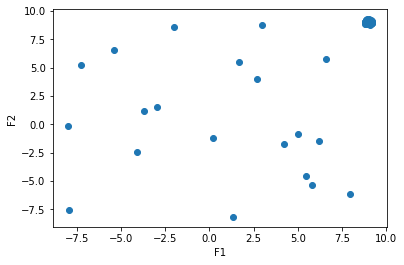

In [52]:
from pyod.utils.data import generate_data, get_outliers_inliers

#generate random data with two features
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# by default the outlier fraction is 0.1 in generate data function 
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 

In [ ]:
# train kNN detector
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split()

clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
# If you want to see the predictions of the training data, you can use this way:
y_train_scores = clf.decision_scores_

In [116]:
from pyod.models.iforest import IForest

outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(xx)
scores_pred = clf.decision_function(xx) * -1

y_pred = clf.predict(xx)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

btc1 = btc
btc1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(btc1['close'][btc1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(btc1['volumeto'][btc1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = btc1['close'][btc1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = btc1['volumeto'][btc1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

ValueError: Length of values does not match length of index

<Figure size 576x576 with 0 Axes>